自注意力机制
起因: 希望对于一个序列来说, 自己产生key,query等值, 不必通过encode,decode等操作

给定序列x1.….Xn
自注意力池化层将xi当做key,value，query来对序列抽取特征得到Y1，.…. Yn，
这里Yi = f(xi, (x1, x1),.……,(xn, xn))

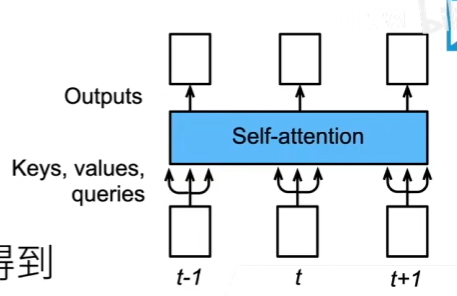

CNN, RNN, 自注意力都可以用于处理序列:

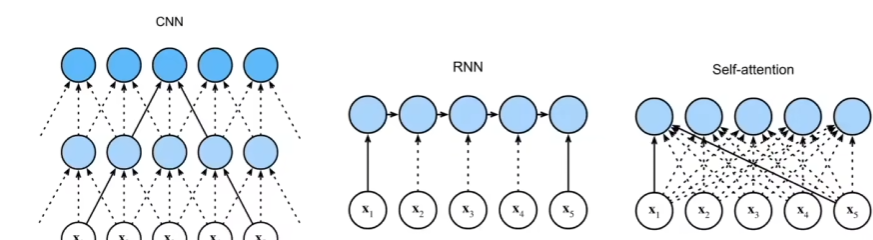
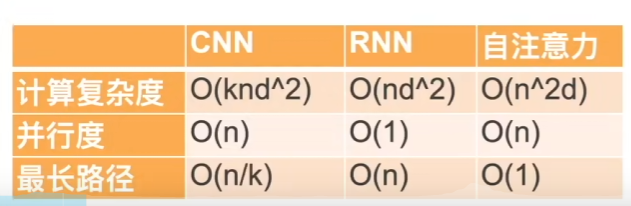

可以看到, sef-attention处理序列是, 序列中各项的路径都是直达的, 所以使用自注意力时, 常常直接加入长序列处理

位置编码
与CNN和RNN不同, 自注意力并没有记录位置信息
此时, 使用位置编码记录位置信息
这样的话我们就使用X+P(位置编码)作为编码输入
而其中P的本质是一个三角函数, 不同的行数(第i个序列)对于加上三角函数不同的位置, 以达成区分位置的效果

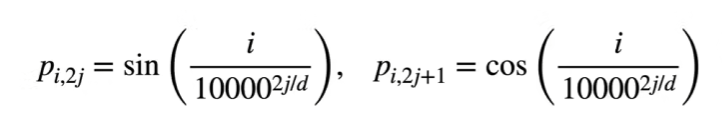
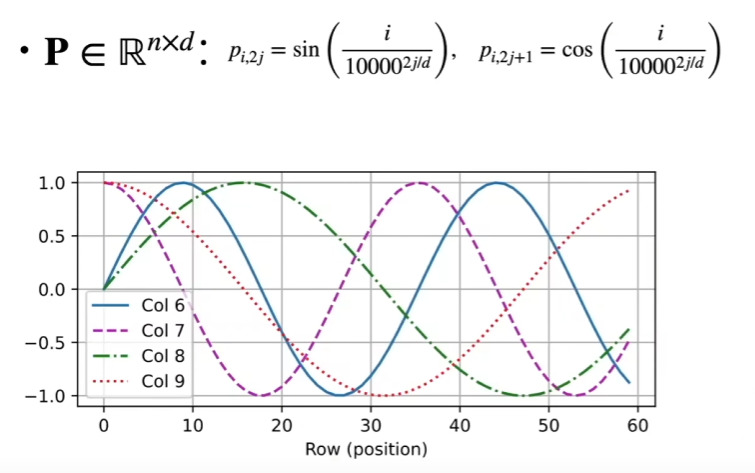

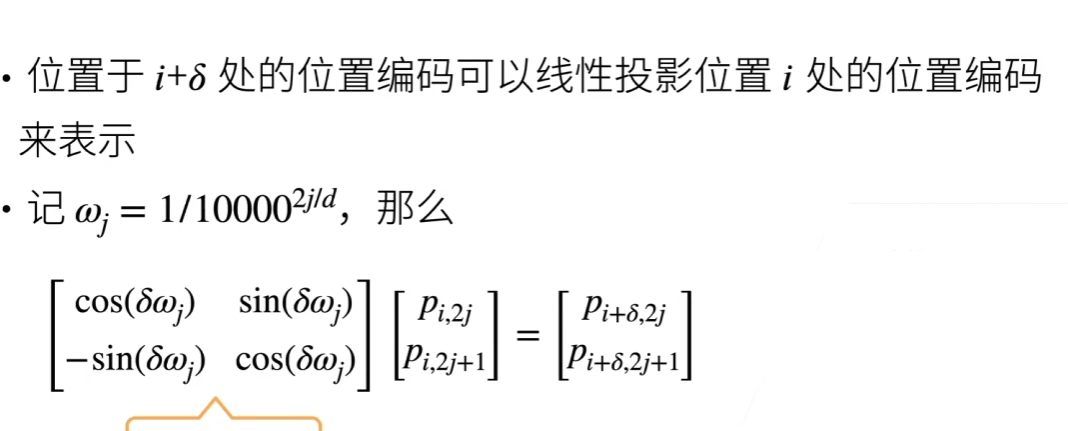

·自注意力池化层将x;当做key，value，query来对序列抽取特征
·完全并行、最长序列为1、但对长序列计算复杂度高
·位置编码在输入中加入位置信息，使得自注意力能够记忆位置信息

transformer架构
基于编码器和解码器的架构来处理序列对
如果是seq2seq是引入注意力机制, 那么transformer就是基于注意力机制

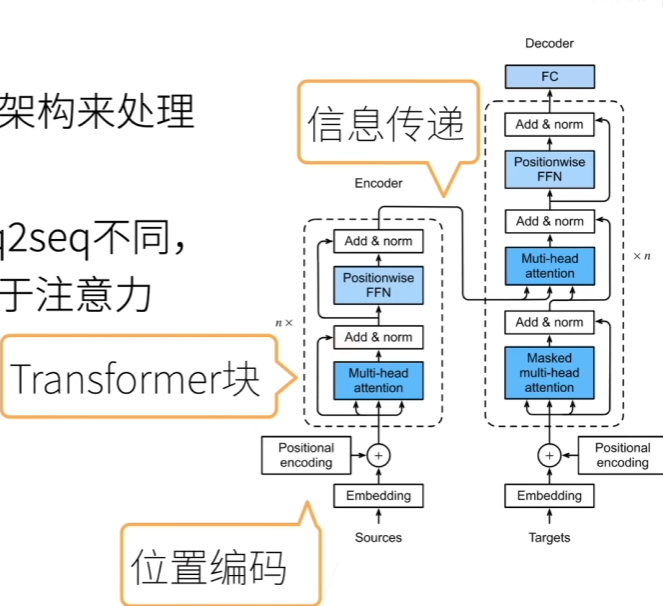

1.Transformer架构分析
Transformer由编码器（Encoder）​和解码器（Decoder）​堆叠组成，两者均通过多头注意力机制（Multi-head Attention）和位置感知前馈网（Position-wise FFN）处理序列数据
特点:
​并行化处理​：无需RNN的时序依赖，通过自注意力机制捕捉全局关系。
​残差连接与层归一化​（Add & Norm）：每个子层（注意力/FFN）后使用，缓解梯度消失。
​位置编码（Positional Encoding）​​：注入序列位置信息，弥补无时序结构的缺陷。

2. 编码器（Encoder）​​
a.​输入处理​：
    ​嵌入层（Embedding）​​：将输入词符映射为稠密向量。
    ​位置编码​：叠加正弦/余弦位置信号，保留序列顺序
​b.核心模块（重复N次）​​：
    -​多头自注意力（Multi-head Attention）​​：
        并行计算多组注意力头，捕捉不同子空间的依赖关系。
        公式：Attention(Q,K,V) = softmax(QK^T/√d_k)V。
    ​-前馈网络（Position-wise FFN）​​：
        两层全连接（中间含ReLU），独立处理每个位置。
    ​-Add & Norm​：残差连接（输入+子层输出）后接层归一化

3. 解码器（Decoder）​​
a.​输入处理​：
    ​目标序列嵌入+位置编码​：类似编码器，但解码时右移一位（避免未来信息泄露）。
b.​核心模块（重复N次）​​：
    -​掩码多头注意力（Masked Multi-head Attention）​​：
        通过掩码（上三角矩阵设为-∞）确保当前位置仅依赖之前位置。
    -​编码器-解码器注意力（Multi-head Attention）​​：
        Query来自解码器，Key/Value来自编码器，实现跨序列对齐。
    -​前馈网络与Add & Norm​：与编码器相同。
c.​输出层​：线性层+Softmax生成目标词符概率。

多头注意力
对同一组key,query,value抽取不同的信息
于是对于一组输入, 使用多个attention, 然后再合并各个头,拿到最终的输出

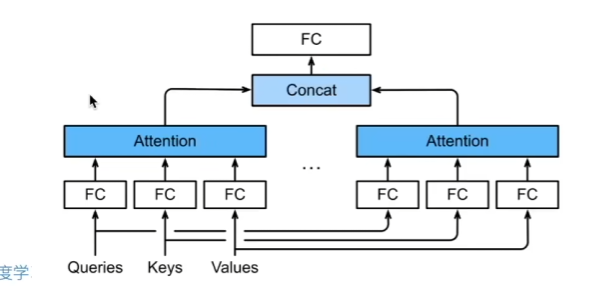

对于q,k,v
头i具有额外的课学习参数Wq,Wk,Wv
输出hi=f(Wq*q,Wk*k,Wv*v) [f()是注意力的相关函数]

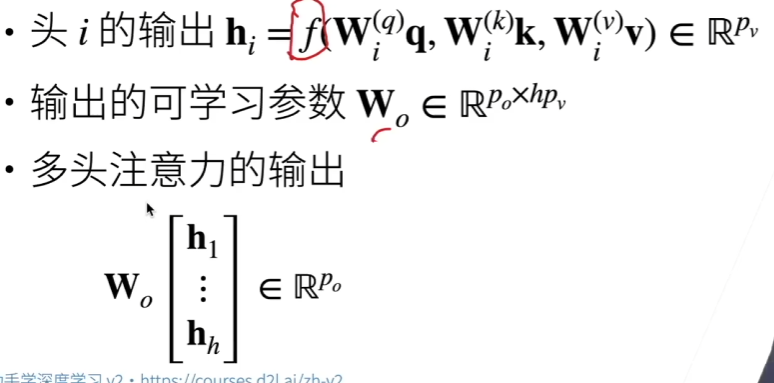

有掩码的多头注意力
解码(输出文字)的时候,我们不应该考虑该元素之后的元素
可以通过掩码来实现

基于位置的前馈网络(Positionwise FFN)
将输入形状由(b,n,d)变换成(bn, d)
作用两个全连接层
输出形状由(bn,d)变化回(b,n, d)
等价于两层核窗口为1的一维卷积层

层归一化
我们不想依赖会变的序列长度进行批量归一化, 这样生成的张量中有不确定的量
于是我们进行层归一化

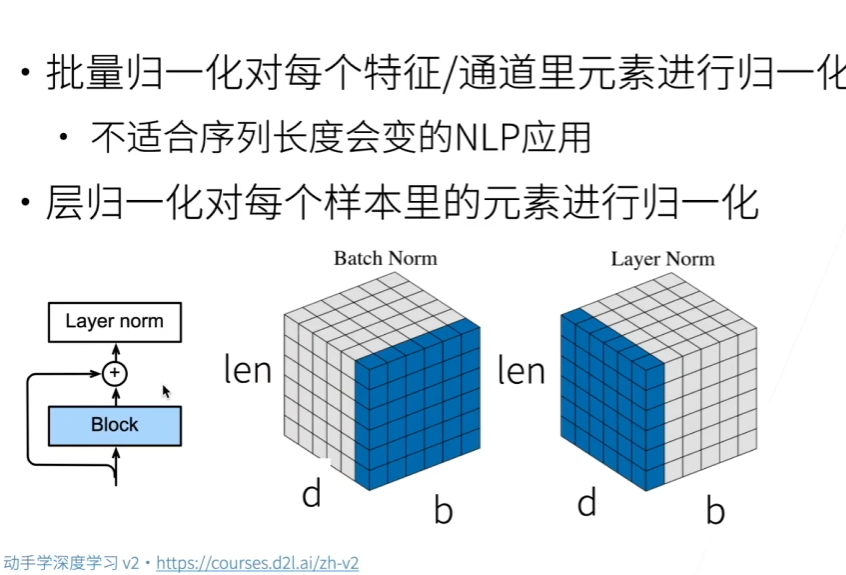

信息传递:
编码器的输出y1...yn会作为解码器中的第i个Transformer块中多头注意力的key和value(这里就是正常的注意力, 其他地方就是自注意力);其query来自目标序列,意味着编码器和解码器中块的个数和输出维度都是一样的

预测阶段
预测第t+1个输出时, 解码器中输入前t个预测值, 在自注意力中1到t-1作为key和value,t作为query

·Transformer是一个纯使用注意力的编码-解码器
·编码器和解码器都有n个transformer块
·每个块里使用多头（自）注意力，基于位置的前馈网络，和层归一化

In [ ]:
# 代码实现
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 定义了一个名为PositionWiseFFN的类，继承自nn.Module
class PositionWiseFFN(nn.Module):
    # __init__方法用于初始化网络
    # ffn_num_input: 输入特征的维度
    # ffn_num_hiddens: 隐藏层的维度
    # ffn_num_outputs: 输出特征的维度
    # **kwargs: 其他可选参数，传递给父类
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        # 网络层
        # dense1: 第一个全连接层，将输入维度从ffn_num_input映射到ffn_num_hiddens
        # relu: ReLU激活函数层
        # dense2: 第二个全连接层，将隐藏层维度从ffn_num_hiddens映射回ffn_num_outputs
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    # 前向传播方法
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [ ]:
# 改变张量的最里层维度的尺寸
# 如何实例化一个位置前馈网络
    # 将网络设置为评估模式
    # 处理一个batch的输入数据（2个样本，每个样本有3个位置/时间步，每个位置有4个特征）
    # 查看第一个样本的输出结果
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

In [ ]:
# 使用残差连接和层归一化
class AddNorm(nn.Module):
    # normalized_shape: 需要进行归一化的特征维度
    # dropout: dropout概率
    # **kwargs: 其他可选参数
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout) # 子模块1: self.dropout: dropout层，用于随机失活部分神经元
        self.ln = nn.LayerNorm(normalized_shape) # 子模块2: self.ln: 层归一化(Layer Normalization)
    #  前向传播: 对Y应用dropout, 将dropout后的Y与原始输入X相加（残差连接）, 对相加结果应用层归一化
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [ ]:
# 实现编码器中的一个层: Transformer编码器的基本构建块
class EncoderBlock(nn.Module):
    # key_size, query_size, value_size: 注意力机制中键、查询和值的维度
    # num_hiddens: 隐藏层维度
    # norm_shape: 层归一化的形状
    # ffn_num_input: 前馈网络输入维度
    # ffn_num_hiddens: 前馈网络隐藏层维度
    # num_heads: 多头注意力的头数
    # dropout: dropout概率
    # use_bias: 是否使用偏置项
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias) # 子模块: self.attention: 多头注意力机制
        self.addnorm1 = AddNorm(norm_shape, dropout) # 子模块: self.addnorm1: 第一个Add & Norm层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens) # 子模块: self.ffn: 位置前馈网络
        self.addnorm2 = AddNorm(norm_shape, dropout) # 子模块: self.addnorm2: 第二个Add & Norm层

    def forward(self, X, valid_lens):
        # 输入: X, valid_lens
        #  ​自注意力阶段: 通过多头注意力计算self.attention(X, X, X, valid_lens); 将注意力输出与原始输入X通过第一个AddNorm层
        # ​前馈网络阶段:将上一步结果Y通过位置前馈网络, 将前馈网络输出与Y通过第二个AddNorm层,  返回最终结果
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

自注意力机制​：使用相同的X作为查询、键和值输入
​残差连接​：通过AddNorm实现，有助于梯度流动
​两次归一化​：分别在注意力和前馈网络后应用
​位置前馈​：对每个位置独立进行非线性变换

参数说明：
vocab_size: 词汇表大小
key_size, query_size, value_size: 注意力机制的维度
num_hiddens: 隐藏层维度（也是嵌入维度）
norm_shape: 层归一化的形状
ffn_num_input, ffn_num_hiddens: 前馈网络的维度
num_heads: 多头注意力的头数
num_layers: 编码器块的层数
dropout: dropout概率
use_bias: 是否使用偏置项

In [ ]:
# 根据之前构建好的模块, 组合构建transformer编码器
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens) # self.embedding: 词嵌入层，将词索引映射为向量
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) # self.pos_encoding: 位置编码，添加序列位置信息
        self.blks = nn.Sequential() # self.blks: 由多个EncoderBlock组成的序列
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

# 前向传播方法: 输入X, valid_lens, 其他参数
    def forward(self, X, valid_lens, *args):
        # ​位置编码​：添加位置信息(嵌入层​：将词索引转换为向量; 缩放嵌入​：乘以sqrt(num_hiddens)以保持数值稳定性)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # 编码器块处理​：通过多个编码器块逐层处理
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            # 存储注意力权重​：记录每层的注意力权重用于可视化
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [ ]:
# 例: 创建一个两层的Transformer编码器
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

key_size, query_size, value_size: 注意力机制的维度
num_hiddens: 隐藏层维度
norm_shape: 层归一化的形状
ffn_num_input, ffn_num_hiddens: 前馈网络的维度
num_heads: 多头注意力的头数
dropout: dropout概率
i: 当前解码器块的索引/层数

In [ ]:
# 定义一个基本的Decoder块: Transformer解码器也是由多个相同的层组成
class DecoderBlock(nn.Module):
    """解码器中第 i 个块"""
    # 初始化方法
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout) # 子模块1: self.attention1: 第一个多头注意力(自注意力)
        self.addnorm1 = AddNorm(norm_shape, dropout) # 子模块2: self.addnorm1: 第一个Add & Norm层
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout) #子模块3: 第二个Add & Norm层
        self.addnorm2 = AddNorm(norm_shape, dropout) # 第二个Add & Norm层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens) # self.ffn: 位置前馈网络
        self.addnorm3 = AddNorm(norm_shape, dropout) # self.addnorm3: 第三个Add & Norm层

    # state: 包含三个元素的元组：enc_outputs: 编码器输出; enc_valid_lens: 编码器有效长度; 存储每层键值对的列表(用于自注意力)
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 如果是第一次运行，直接使用当前输入X, 否则将当前输入与缓存的键值拼接
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        # 训练时创建解码器有效长度掩码(防止看到未来信息), 推理时不需要(使用缓存机制)
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        X2 = self.attention1(X, key_values, key_values, dec_valid_lens) # 计算自注意力(带掩码)
        Y = self.addnorm1(X, X2) # 残差连接 + 层归一化
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # 计算编码器-解码器注意力(查询来自解码器，键值来自编码器)
        Z = self.addnorm2(Y, Y2) # 残差连接 + 层归一化
        # 通过位置前馈网络 & 残差连接 + 层归一化 返回输出和更新后的状态
        return self.addnorm3(Z, self.ffn(Z)), state

vocab_size: 词汇表大小
key_size, query_size, value_size: 注意力机制的维度
num_hiddens: 隐藏层维度（也是嵌入维度）
norm_shape: 层归一化的形状
ffn_num_input, ffn_num_hiddens: 前馈网络的维度
num_heads: 多头注意力的头数
num_layers: 解码器块的层数
dropout: dropout概率

In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens) # self.embedding: 词嵌入层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) # self.pos_encoding: 位置编码
        self.blks = nn.Sequential() # elf.blks: 由多个DecoderBlock组成的序列
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size) # self.dense: 输出全连接层（将隐藏状态映射回词汇表空间）

    # 初始化解码器状态: enc_outputs: 编码器输出; enc_valid_lens: 编码器有效长度
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers] # 为每层初始化一个None值

    # 前向传播方法
    # 输入处理: 词嵌入; 缩放嵌入（乘以sqrt(num_hiddens)）; 添加位置编码
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        # 初始化注意力权重存储结构（用于两种注意力）
        for i, blk in enumerate(self.blks): # 通过每个解码器块, 存储两种注意力权重
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights # attention1: 自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights # attention2: 编码器-解码器注意力权重
        return self.dense(X), state

    # 提供访问注意力权重的接口
    @property
    def attention_weights(self):
        return self._attention_weights

NameError: name 'd2l' is not defined

​模型架构参数:

num_hiddens=32: 隐藏层维度
num_layers=2: 编码器和解码器的层数
dropout=0.1: Dropout率
num_heads=4: 多头注意力的头数
ffn_num_hiddens=64: 前馈网络隐藏层维度
​训练参数:

batch_size=64: 批量大小
num_steps=10: 序列长度
lr=0.005: 学习率
num_epochs=200: 训练轮数

In [ ]:
# 参数设置
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
# 数据加载
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
# 模型构建
encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout) # 编码器
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout) # 编码器
net = d2l.EncoderDecoder(encoder, decoder) # 将编码器和解码器组合成Seq2Seq架构
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) # 模型训练

BERT
从图片处理得到灵感, 以微调和迁移的方式进行文字处理
BERT: 一个只有编码器的transformer
增大模型体量, 抽取合适的特征, 便于之后的学习

对输入的修改:
每个样本是一个句子对(比如: <cls>this movie isgreat<sep>i like it <sep>就是由两个句子组成的句子对)
加入额外的片段嵌入
位置编码可学习

预测任务1: 带musk的语言模型(完形填空)
按一个概率(15%)选择一些词: 对这个词, 80%替换为musk, 10%替换为一个随机词元, 10%保持原状
预训练任务2: 下一个句子的预测(预测两个句子是否相邻)
训练样本中: 50%概率选择相邻句子对, 50%概率选择随机句子对

·BERT针对微调设计
·基于Transformer的编码器做了如下修改
·模型更大，训练数据更多
·输入句子对，片段嵌入，可学习的位置编码
·训练时使用两个任务：
    带掩码的语言模型
    下一个句子预测

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 将输入的token序列转换为BERT模型所需的格式，并生成对应的segment ID
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [ ]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens) # token_embedding: 词嵌入(将词索引映射为向量)
        self.segment_embedding = nn.Embedding(2, num_hiddens) # segment_embedding: 段落嵌入(区分句子A和B)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens)) # 使用可学习的位置编码(与原始Transformer的正弦编码不同)

    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments) # 词嵌入 + 段落嵌入
        X = X + self.pos_embedding.data[:, :X.shape[1], :] # 加上位置编码
        for blk in self.blks: # 通过多层Transformer编码器
            X = blk(X, valid_lens)
        return X

In [ ]:
# 掩码语言模型(Masked Language Model, MLM)任务的实现
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        # 在BERT的基础上构建一个多层感知机(MLP)：
        # 线性层：num_inputs → num_hiddens
        # ReLU激活函数
        # 层归一化
        # 线性层：num_hiddens → vocab_size
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        # 首先处理预测位置
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        # 为每个预测位置创建对应的batch索引
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        # 提取被掩码位置的隐藏状态
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        # 通过MLP进行预测
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

NameError: name 'nn' is not defined

In [ ]:
# 接在BERT编码器之后; 使用[CLS]标记的聚合信息进行预测
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        # 构建一个简单的线性分类器
        self.output = nn.Linear(num_inputs, 2)

    # 前向传播方法
    def forward(self, X):
        return self.output(X)

参数说明：
vocab_size: 词汇表大小
num_hiddens: 隐藏层维度(默认768)
norm_shape: 层归一化的形状
ffn_num_input, ffn_num_hiddens: 前馈网络的维度
num_heads: 多头注意力的头数
num_layers: Transformer层数
dropout: dropout概率
max_len: 最大序列长度
key_size, query_size, value_size: 注意力机制的维度
hid_in_features, mlm_in_features, nsp_in_features: 各任务的输入维度

In [ ]:
# 结合成完整的BERT模型实现，结合了BERT编码器、掩码语言模型(MLM)和下一个句子预测(NSP)任务
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        # BERT编码器：负责将输入token转换为隐藏表示
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        # 隐藏层转换：用于NSP任务前的特征转换, 包含线性层和Tanh激活
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        # 两个预训练任务：
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    # 前向传播方法
    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        # 首先通过BERT编码器获取隐藏表示
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None

        # 使用[CLS]标记的隐藏状态(第一个位置)进行NSP预测
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat